 # Astro Trading Pipeline - Modular Research Notebook



 This is the **central orchestrating notebook** that imports and runs all modules.



 ## Pipeline Steps:

 1. Setup & Config

 2. Load Market Data (from PostgreSQL)

 3. Visualize Price

 4. Create Labels (balanced UP/DOWN)

 5. Compute Astro Data

 6. Build Features

 7. Train Model

 8. Evaluate & Visualize

 9. (Optional) Grid Search

 10. Save Model

 ## 0. Environment Check

In [155]:
# Check dependencies
import importlib.util as iu

required = ["xgboost", "sklearn", "matplotlib", "seaborn", "tqdm", "pyarrow", "psycopg2", "swisseph"]
missing = [pkg for pkg in required if iu.find_spec(pkg) is None]

if missing:
    print("Missing packages:", ", ".join(missing))
    print("Install with: conda install -c conda-forge " + " ".join(missing))
else:
    print("✓ All dependencies found")


✓ All dependencies found


 ## 1. Setup & Configuration

In [156]:
# Import RESEARCH modules
import sys
from pathlib import Path

# Find project root and add to path
PROJECT_ROOT = Path.cwd().resolve()
if not (PROJECT_ROOT / "RESEARCH").exists():
    for parent in PROJECT_ROOT.parents:
        if (parent / "RESEARCH").exists():
            PROJECT_ROOT = parent
            break

if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

print(f"PROJECT_ROOT: {PROJECT_ROOT}")


PROJECT_ROOT: /home/rut/ostrofun


In [157]:
# Import all modules
from RESEARCH.config import cfg, PROJECT_ROOT
from RESEARCH.data_loader import load_market_data, get_latest_date, get_data_paths
from RESEARCH.labeling import create_balanced_labels, gaussian_smooth_centered
from RESEARCH.astro_engine import (
    init_ephemeris,
    calculate_bodies_for_dates,
    calculate_aspects_for_dates,
    calculate_transits_for_dates,
    get_natal_bodies,
)
from RESEARCH.features import (
    build_full_features,
    merge_features_with_labels,
    get_feature_columns,
    get_feature_inventory,
)
from RESEARCH.model_training import (
    split_dataset,
    prepare_xy,
    train_xgb_model,
    tune_threshold,
    predict_with_threshold,
    evaluate_model,
    get_feature_importance,
    check_cuda_available,
)
from RESEARCH.visualization import (
    plot_price_distribution,
    plot_class_distribution,
    plot_price_with_labels,
    plot_last_n_days,
    plot_confusion_matrix,
    plot_feature_importance,
    plot_predictions,
)

print("✓ All RESEARCH modules imported")


✓ All RESEARCH modules imported


In [158]:
# Show configuration
print(f"Active subject: {cfg.active_subject_id}")
print(f"Data root: {cfg.data_root}")
print(f"DB URL configured: {bool(cfg.db_url)}")
print(f"Label config: {cfg.get_label_config()}")


Active subject: btc
Data root: /home/rut/ostrofun/data/market
DB URL configured: True
Label config: {'horizon': 1, 'target_move_share': 0.5, 'gauss_window': 201, 'gauss_std': 50.0, 'price_mode': 'raw'}


 ## 2. Load Market Data

In [159]:
# Load market data from database
df_market = load_market_data()

# Optional: filter by start date
DATA_START = "2017-11-01"
df_market = df_market[df_market["date"] >= DATA_START].reset_index(drop=True)

print(f"\nMarket data: {len(df_market)} rows")
print(f"Date range: {df_market['date'].min().date()} → {df_market['date'].max().date()}")
df_market.head()


Loaded 5677 rows from DB for subject=btc
Date range: 2010-07-18 -> 2026-01-31

Market data: 3014 rows
Date range: 2017-11-01 → 2026-01-31


/home/rut/ostrofun/RESEARCH/data_loader.py:55: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn, params=params)


,date,close
0,2017-11-01,6737.8
1,2017-11-02,7024.8
2,2017-11-03,7152.1
3,2017-11-04,7363.8
4,2017-11-05,7389.5


 ## 3. Visualize Price

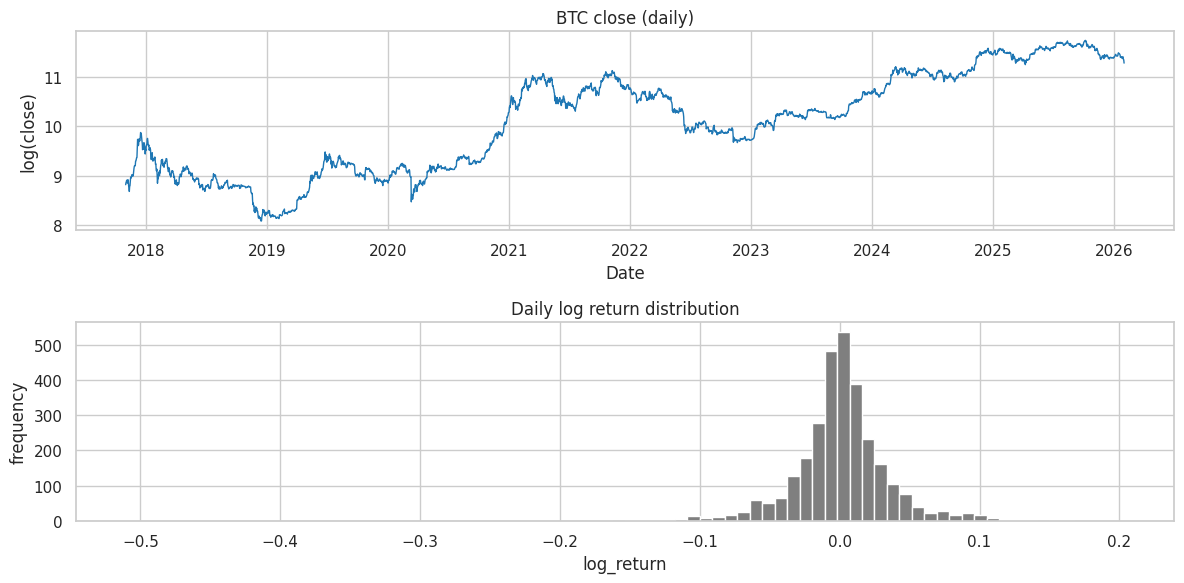

In [160]:
# Price and return distribution
plot_price_distribution(df_market, price_mode="log")


 ## 4. Create Labels

In [161]:
# Configuration for labeling
LABEL_CONFIG = {
    "horizon": 1,           # Prediction horizon (days)
    "move_share": 0.5,      # Total share of samples to keep
    "gauss_window": 201,    # Gaussian window for detrending (odd)
    "gauss_std": 50.0,      # Gaussian std
    "price_mode": "raw",    # 'raw' or 'log'
    "label_mode": "balanced_detrended",
}

# Create balanced labels
df_labels = create_balanced_labels(
    df_market,
    horizon=LABEL_CONFIG["horizon"],
    move_share=LABEL_CONFIG["move_share"],
    gauss_window=LABEL_CONFIG["gauss_window"],
    gauss_std=LABEL_CONFIG["gauss_std"],
    price_mode=LABEL_CONFIG["price_mode"],
    label_mode=LABEL_CONFIG["label_mode"],
)

df_labels.head()


Labels created: 1506 samples
  UP: 753 (50.0%)
  DOWN: 753 (50.0%)
  Date range: 2017-11-05 -> 2026-01-30


,date,close,target
0,2017-11-05,7389.5,0
1,2017-11-08,7444.4,0
2,2017-11-09,7129.6,0
3,2017-11-11,6339.9,0
4,2017-11-12,5878.1,1


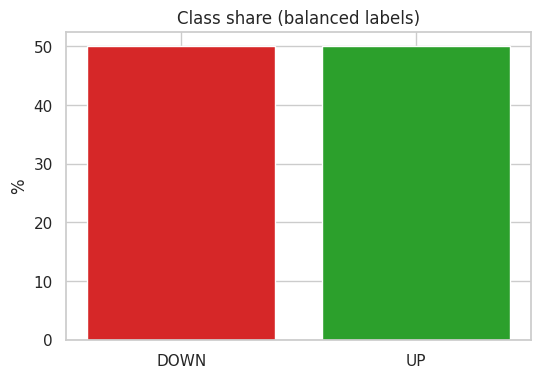

In [162]:
# Class distribution
plot_class_distribution(df_labels)


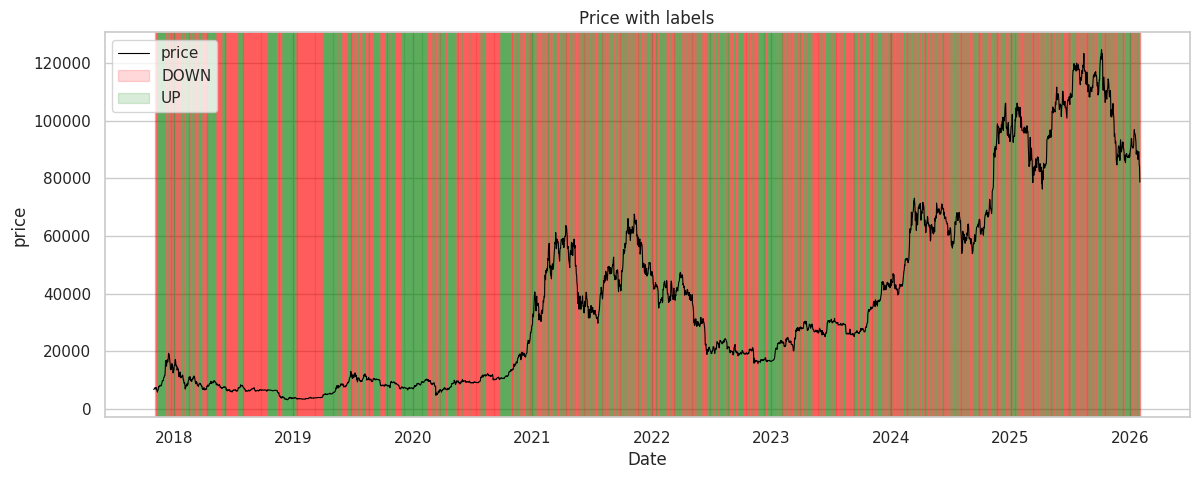

In [163]:
# Price with labels
plot_price_with_labels(df_market, df_labels, price_mode="raw")


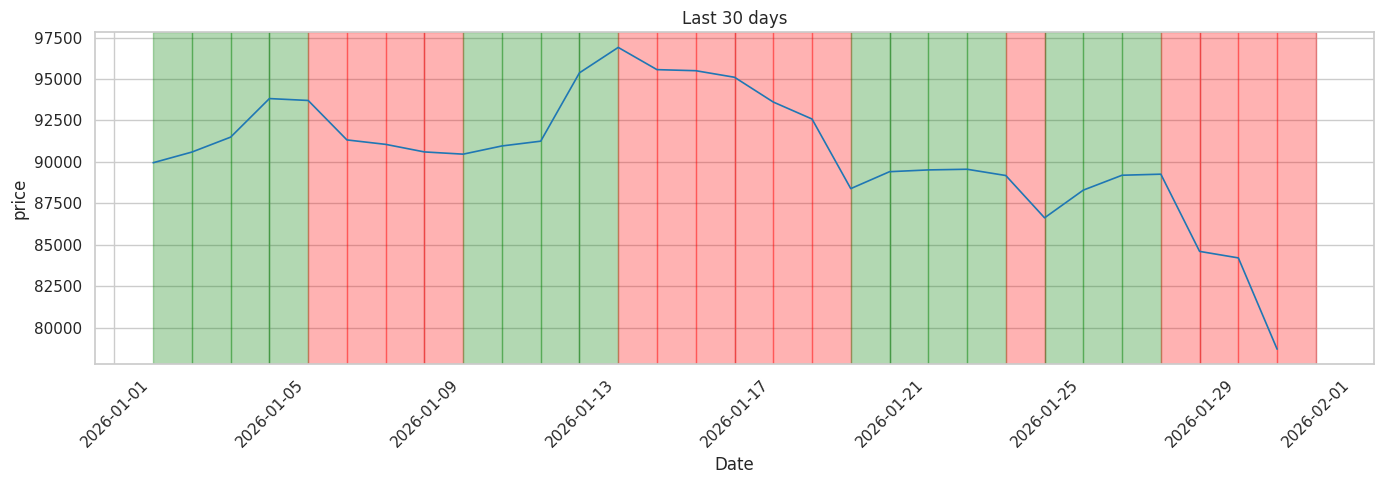

Last 30 days: 30 labeled (forward-filled) out of 30


In [164]:
# Last 30 days
plot_last_n_days(df_market, df_labels, n_days=30)


 ## 5. Compute Astro Data

In [165]:
# Initialize ephemeris
settings = init_ephemeris()
print(f"Bodies: {[b.name for b in settings.bodies]}")
print(f"Aspects: {[a.name for a in settings.aspects]}")


Bodies: ['Sun', 'Moon', 'Mercury', 'Venus', 'Mars', 'Jupiter', 'Saturn', 'Uranus', 'Neptune', 'Pluto', 'TrueNode', 'MeanNode', 'Lilith']
Aspects: ['Conjunction', 'Sextile', 'Square', 'Trine', 'Opposition']


In [166]:
# Calculate body positions for all dates
# (This is fast - no need to cache)
df_bodies, bodies_by_date = calculate_bodies_for_dates(
    df_market["date"],
    settings,
    progress=True,
)

print(f"\nBodies calculated: {len(df_bodies)} rows")
df_bodies.head()


Calculating bodies: 100%|██████████| 3014/3014 [00:00<00:00, 24695.13it/s]


Bodies calculated: 39182 rows


,date,body,lon,lat,speed,is_retro,sign,declination
0,2017-11-01,Sun,218.755657,-0.000011,1.000008,False,Scorpio,-0.000011
1,2017-11-01,Moon,356.209228,-2.907350,13.493332,False,Pisces,-2.907350
2,2017-11-01,Mercury,232.905646,-1.409936,1.497015,False,Scorpio,-1.409936
3,2017-11-01,Venus,201.888931,1.488282,1.249436,False,Libra,1.488282
4,2017-11-01,Mars,185.828074,1.137132,0.631064,False,Libra,1.137132


In [167]:
# Calculate aspects
ORB_MULTIPLIER = 0.25  # Best from grid search (tight aspects)

df_aspects = calculate_aspects_for_dates(
    bodies_by_date,
    settings,
    orb_mult=ORB_MULTIPLIER,
    progress=True,
)

print(f"\nAspects: {len(df_aspects)} rows")
df_aspects.head()


Calculating aspects (orb=0.25): 100%|██████████| 3014/3014 [00:00<00:00, 49704.85it/s]


Aspects: 14088 rows


,date,p1,p2,aspect,orb,is_exact,is_applying
0,2017-11-01,TrueNode,MeanNode,Conjunction,0.873850,False,True
1,2017-11-02,TrueNode,MeanNode,Conjunction,0.812445,False,True
2,2017-11-03,Sun,Neptune,Trine,0.816923,False,True
3,2017-11-03,Moon,Venus,Opposition,0.274432,False,False
4,2017-11-03,Moon,Saturn,Trine,0.684597,False,False


 ## 6. Build Features

In [168]:
# Build feature matrix
df_features = build_full_features(
    df_bodies,
    df_aspects,
    df_transits=None,  # Add transit aspects if needed
    include_pair_aspects=True,
    include_transit_aspects=False,
    exclude_bodies=["Uranus", "Pluto"],  # Best from grid search - these add noise
)

print(f"Features shape: {df_features.shape}")
df_features.head()


Features shape: (3014, 556)


,date,Jupiter_lon,Lilith_lon,Mars_lon,MeanNode_lon,Mercury_lon,Moon_lon,Neptune_lon,Saturn_lon,Sun_lon,TrueNode_lon,Venus_lon,Jupiter_speed,Lilith_speed,Mars_speed,MeanNode_speed,Mercury_speed,Moon_speed,Neptune_speed,Saturn_speed,Sun_speed,TrueNode_speed,Venus_speed,Jupiter_is_retro,Lilith_is_retro,Mars_is_retro,MeanNode_is_retro,Mercury_is_retro,Moon_is_retro,Neptune_is_retro,Saturn_is_retro,Sun_is_retro,TrueNode_is_retro,Venus_is_retro,Jupiter_declination,Lilith_declination,Mars_declination,MeanNode_declination,Mercury_declination,Moon_declination,Neptune_declination,Saturn_declination,Sun_declination,TrueNode_declination,Venus_declination,Jupiter_sign_idx,Lilith_sign_idx,Mars_sign_idx,MeanNode_sign_idx,Mercury_sign_idx,Moon_sign_idx,Neptune_sign_idx,Saturn_sign_idx,Sun_sign_idx,TrueNode_sign_idx,Venus_sign_idx,aspect_hit_Jupiter__Lilith__Sextile,aspect_hit_Jupiter__Lilith__Square,aspect_hit_Jupiter__Lilith__Trine,aspect_hit_Jupiter__Mars__Conjunction,aspect_hit_Jupiter__Mars__Opposition,aspect_hit_Jupiter__Mars__Sextile,aspect_hit_Jupiter__Mars__Square,aspect_hit_Jupiter__Mars__Trine,aspect_hit_Jupiter__MeanNode__Conjunction,aspect_hit_Jupiter__MeanNode__Opposition,aspect_hit_Jupiter__MeanNode__Sextile,aspect_hit_Jupiter__MeanNode__Square,aspect_hit_Jupiter__MeanNode__Trine,aspect_hit_Jupiter__Mercury__Conjunction,aspect_hit_Jupiter__Mercury__Opposition,aspect_hit_Jupiter__Mercury__Sextile,aspect_hit_Jupiter__Mercury__Square,aspect_hit_Jupiter__Mercury__Trine,aspect_hit_Jupiter__Moon__Conjunction,aspect_hit_Jupiter__Moon__Opposition,aspect_hit_Jupiter__Moon__Sextile,aspect_hit_Jupiter__Moon__Square,aspect_hit_Jupiter__Moon__Trine,aspect_hit_Jupiter__Neptune__Conjunction,aspect_hit_Jupiter__Neptune__Sextile,aspect_hit_Jupiter__Neptune__Square,aspect_hit_Jupiter__Neptune__Trine,aspect_hit_Jupiter__Saturn__Conjunction,aspect_hit_Jupiter__Saturn__Sextile,aspect_hit_Jupiter__Saturn__Square,aspect_hit_Jupiter__Saturn__Trine,aspect_hit_Jupiter__Sun__Conjunction,aspect_hit_Jupiter__Sun__Opposition,aspect_hit_Jupiter__Sun__Sextile,aspect_hit_Jupiter__Sun__Square,aspect_hit_Jupiter__Sun__Trine,aspect_hit_Jupiter__TrueNode__Conjunction,aspect_hit_Jupiter__TrueNode__Opposition,aspect_hit_Jupiter__TrueNode__Sextile,aspect_hit_Jupiter__TrueNode__Square,aspect_hit_Jupiter__TrueNode__Trine,aspect_hit_Jupiter__Venus__Conjunction,aspect_hit_Jupiter__Venus__Opposition,aspect_hit_Jupiter__Venus__Sextile,aspect_hit_Jupiter__Venus__Square,aspect_hit_Jupiter__Venus__Trine,aspect_hit_Lilith__Mars__Conjunction,aspect_hit_Lilith__Mars__Opposition,aspect_hit_Lilith__Mars__Sextile,aspect_hit_Lilith__Mars__Square,aspect_hit_Lilith__Mars__Trine,aspect_hit_Lilith__MeanNode__Conjunction,aspect_hit_Lilith__MeanNode__Opposition,aspect_hit_Lilith__MeanNode__Sextile,aspect_hit_Lilith__MeanNode__Square,aspect_hit_Lilith__MeanNode__Trine,aspect_hit_Lilith__Mercury__Conjunction,aspect_hit_Lilith__Mercury__Opposition,aspect_hit_Lilith__Mercury__Sextile,aspect_hit_Lilith__Mercury__Square,aspect_hit_Lilith__Mercury__Trine,aspect_hit_Lilith__Moon__Conjunction,aspect_hit_Lilith__Moon__Opposition,aspect_hit_Lilith__Moon__Sextile,aspect_hit_Lilith__Moon__Square,aspect_hit_Lilith__Moon__Trine,aspect_hit_Lilith__Neptune__Conjunction,aspect_hit_Lilith__Neptune__Opposition,aspect_hit_Lilith__Neptune__Sextile,aspect_hit_Lilith__Neptune__Square,aspect_hit_Lilith__Neptune__Trine,aspect_hit_Lilith__Saturn__Opposition,aspect_hit_Lilith__Saturn__Sextile,aspect_hit_Lilith__Saturn__Square,aspect_hit_Lilith__Saturn__Trine,aspect_hit_Lilith__Sun__Conjunction,aspect_hit_Lilith__Sun__Opposition,aspect_hit_Lilith__Sun__Sextile,aspect_hit_Lilith__Sun__Square,aspect_hit_Lilith__Sun__Trine,aspect_hit_Lilith__TrueNode__Conjunction,aspect_hit_Lilith__TrueNode__Opposition,aspect_hit_Lilith__TrueNode__Sextile,aspect_hit_Lilith__TrueNode__Square,aspect_hit_Lilith__TrueNode__Trine,aspect_hit_Lilith__Venus__Conjunction,aspect_hit_Lilith__Venus__Opposition,aspect_hit_Lilith__Venus__Sextile,aspec

In [169]:
# Merge with labels
df_dataset = merge_features_with_labels(df_features, df_labels)
print(f"\nDataset shape: {df_dataset.shape}")


Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 555

Dataset shape: (3010, 557)


In [170]:
# Feature inventory
feature_inventory = get_feature_inventory(df_dataset)
print("\nFeature groups:")
print(feature_inventory.groupby("group").size())



Feature groups:
group
Jupiter       5
Lilith        5
Mars          5
MeanNode      5
Mercury       5
Moon          5
Neptune       5
Saturn        5
Sun           5
TrueNode      5
Venus         5
aspect      500
dtype: int64


 ## 7. Train Model

In [171]:
# Check CUDA availability
use_cuda, device = check_cuda_available()
print(f"Using device: {device}")


Using device: cuda


In [172]:
# Split dataset (time-based)
train_df, val_df, test_df = split_dataset(df_dataset, train_ratio=0.7, val_ratio=0.15)

print(f"Train: {train_df['date'].min().date()} → {train_df['date'].max().date()}")
print(f"Val:   {val_df['date'].min().date()} → {val_df['date'].max().date()}")
print(f"Test:  {test_df['date'].min().date()} → {test_df['date'].max().date()}")


Split: Train=2107, Val=451, Test=452
Train: 2017-11-05 → 2023-08-12
Val:   2023-08-13 → 2024-11-05
Test:  2024-11-06 → 2026-01-31


In [173]:
# Prepare X, y
feature_cols = get_feature_columns(df_dataset)
X_train, y_train = prepare_xy(train_df, feature_cols)
X_val, y_val = prepare_xy(val_df, feature_cols)
X_test, y_test = prepare_xy(test_df, feature_cols)

print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_val:   {X_val.shape}, y_val:   {y_val.shape}")
print(f"X_test:  {X_test.shape}, y_test:  {y_test.shape}")


X_train: (2107, 555), y_train: (2107,)
X_val:   (451, 555), y_val:   (451,)
X_test:  (452, 555), y_test:  (452,)


In [174]:
# Train XGBoost model
MODEL_PARAMS = {
    "n_estimators": 500,
    "max_depth": 6,
    "learning_rate": 0.03,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
}

model = train_xgb_model(
    X_train, y_train,
    X_val, y_val,
    feature_cols,
    n_classes=2,
    device=device,
    **MODEL_PARAMS,
)


In [175]:
# Tune threshold on validation set
# ТЕПЕРЬ по умолчанию оптимизирует recall_min (качество худшего класса)
best_threshold, best_score = tune_threshold(model, X_val, y_val)  # metric="recall_min" по умолчанию


🎯 Best threshold=0.50, RECALL_MIN=0.4314, gap=0.1395


 ## 8. Evaluate & Visualize

In [176]:
# Predict on test set
y_pred = predict_with_threshold(model, X_test, threshold=best_threshold)

# Evaluate
results = evaluate_model(y_test, y_pred, label_names=["DOWN", "UP"])



=== Model Evaluation ===
Accuracy: 0.5155
Balanced Accuracy: 0.5158
MCC: 0.0321
F1 Macro: 0.5126
Summary Score: 0.5142

Majority Baseline: acc=0.5022, bal_acc=0.5000
Prev-Label Baseline: acc=0.5708, bal_acc=0.5708

Classification Report:
              precision    recall  f1-score   support

        DOWN       0.51      0.60      0.55       225
          UP       0.52      0.44      0.47       227

    accuracy                           0.52       452
   macro avg       0.52      0.52      0.51       452
weighted avg       0.52      0.52      0.51       452

95% Bootstrap CI:
  acc: [0.4733, 0.5575]
  bal_acc: [0.4744, 0.5550]
  f1_macro: [0.4696, 0.5525]


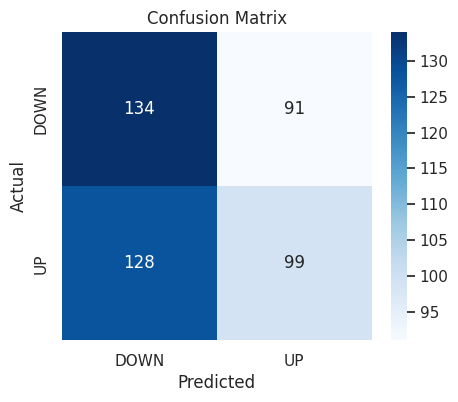

In [177]:
# Confusion matrix
plot_confusion_matrix(y_test, y_pred)


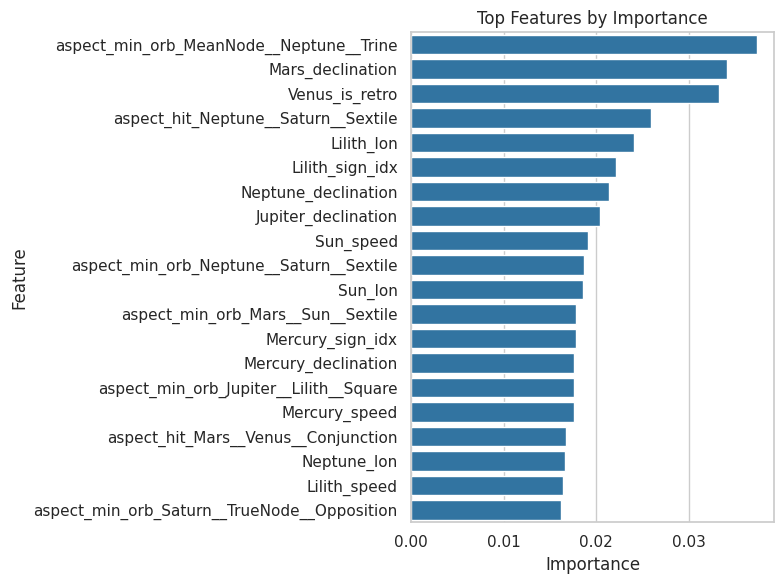

In [178]:
# Feature importance
imp_df = get_feature_importance(model, feature_cols, top_n=20)
plot_feature_importance(imp_df)


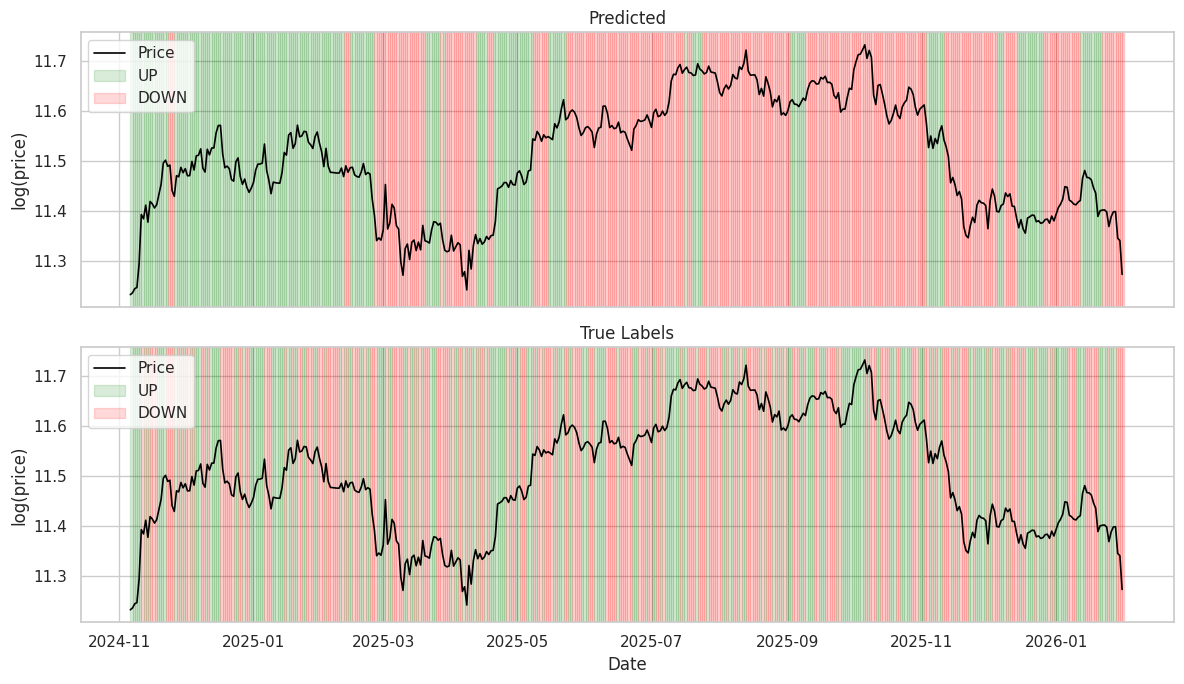

In [179]:
# Predictions on test set
# Теперь df_dataset уже содержит все дни с forward-filled метками
# Нужно только добавить close для визуализации
import pandas as pd  # На случай если запускается отдельно

test_df_plot = test_df.copy()
test_df_plot["date"] = pd.to_datetime(test_df_plot["date"])
test_df_plot = test_df_plot.merge(
    df_market[["date", "close"]].assign(date=lambda x: pd.to_datetime(x["date"])), 
    on="date", 
    how="left"
)

plot_predictions(test_df_plot, y_pred, y_true=y_test, price_mode="log")


 ## 9. (Optional) Grid Search



 Выберите один из вариантов ниже:

 - **run_grid_search** — основной поиск (coord + gauss + orb)

 - **run_full_grid_search** — полный поиск с body ablation

 - **run_body_ablation_search** — только ablation тел

In [180]:
# ══════════════════════════════════════════════════════════════════════════════════
# 🌳 XGBOOST HYPERPARAMETER SEARCH
# ══════════════════════════════════════════════════════════════════════════════════
#
# Этот ноутбук перебирает гиперпараметры XGBoost для двух лучших конфигураций:
#
# CONFIG 1 (старый baseline):
#   geo O=0.25 W=201 S=50.0 -[Uranus,Pluto]
#   R_MIN=0.578, MCC=0.159
#
# CONFIG 2 (новый лучший):
#   both O=0.15 W=300 S=70
#   R_MIN=0.587, MCC=0.182
#
# ══════════════════════════════════════════════════════════════════════════════════

from RESEARCH.grid_search import evaluate_combo
from RESEARCH.astro_engine import init_ephemeris, calculate_bodies_for_dates_multi, precompute_angles_for_dates
from RESEARCH.model_training import check_cuda_available
from itertools import product

# Инициализация
settings = init_ephemeris()
_, device = check_cuda_available()
print(f"🖥️ Устройство: {device}")


🖥️ Устройство: cuda


In [181]:
# ══════════════════════════════════════════════════════════════════════════════════
# 🎛️ КОНФИГУРАЦИИ ДЛЯ ТЕСТИРОВАНИЯ
# ══════════════════════════════════════════════════════════════════════════════════

# Две лучшие конфигурации астро-параметров
CONFIGS = {
    "CONFIG_1": {
        "name": "Old Baseline (geo -Uranus,Pluto)",
        "coord_mode": "geo",
        "orb_mult": 0.25,
        "gauss_window": 201,
        "gauss_std": 50.0,
        "exclude_bodies": ["Uranus", "Pluto"],
        "baseline_r_min": 0.578,
        "baseline_mcc": 0.159,
    },
    "CONFIG_2": {
        "name": "New Best (both -Uranus,Pluto)",
        "coord_mode": "both",
        "orb_mult": 0.15,
        "gauss_window": 300,
        "gauss_std": 70.0,
        "exclude_bodies": ["Uranus", "Pluto"],
        "baseline_r_min": 0.587,
        "baseline_mcc": 0.182,
    },
}

# ══════════════════════════════════════════════════════════════════════════════════
# 🌳 XGBOOST HYPERPARAMETERS — ЧТО ПЕРЕБИРАЕМ
# ══════════════════════════════════════════════════════════════════════════════════

# n_estimators — количество деревьев
N_ESTIMATORS = [100, 200, 300, 500, 700]

# max_depth — глубина дерева (меньше = меньше переобучения)
MAX_DEPTHS = [2, 3, 4, 5, 6]

# learning_rate — скорость обучения
LEARNING_RATES = [0.01, 0.02, 0.03, 0.05, 0.1]

# subsample — доля данных на каждое дерево
SUBSAMPLES = [0.6, 0.7, 0.8, 0.9, 1.0]

# colsample_bytree — доля признаков на каждое дерево
COLSAMPLES = [0.6, 0.7, 0.8, 0.9, 1.0]

# early_stopping_rounds — остановка если валидация не улучшается
# (по умолчанию 50 в XGBBaseline, но можно переопределить)
EARLY_STOPPING = 50

# ──────────────────────────────────────────────────────────────────────────────
# Выбор КАКУЮ конфигурацию тестировать (меняйте здесь!)
# ──────────────────────────────────────────────────────────────────────────────
ACTIVE_CONFIG = "CONFIG_2"  # ← Изменить на "CONFIG_1" для старого baseline

# ──────────────────────────────────────────────────────────────────────────────
# Режим перебора: "full" или "fast"
# ──────────────────────────────────────────────────────────────────────────────
# "full" = все комбинации (5^5 = 3125) — ДОЛГО!
# "fast" = только важные параметры (n_estimators, max_depth, learning_rate)
SEARCH_MODE = "fast"  # ← Изменить на "full" для полного перебора

# Подсчёт комбинаций
if SEARCH_MODE == "full":
    total_combos = len(N_ESTIMATORS) * len(MAX_DEPTHS) * len(LEARNING_RATES) * len(SUBSAMPLES) * len(COLSAMPLES)
    param_combos = list(product(N_ESTIMATORS, MAX_DEPTHS, LEARNING_RATES, SUBSAMPLES, COLSAMPLES))
else:
    total_combos = len(N_ESTIMATORS) * len(MAX_DEPTHS) * len(LEARNING_RATES)
    param_combos = list(product(N_ESTIMATORS, MAX_DEPTHS, LEARNING_RATES, [0.8], [0.8]))

config = CONFIGS[ACTIVE_CONFIG]

print("=" * 80)
print("🌳 XGBOOST HYPERPARAMETER SEARCH")
print("=" * 80)
print(f"""
📊 Тестируем конфигурацию: {config['name']}
   Coord:    {config['coord_mode']}
   Orb:      {config['orb_mult']}
   Window:   {config['gauss_window']}
   Std:      {config['gauss_std']}
   Exclude:  {config['exclude_bodies']}
   
   📌 BASELINE:
      R_MIN = {config['baseline_r_min']:.3f}
      MCC   = {config['baseline_mcc']:.3f}

🎛️ XGBoost параметры для перебора:
   • n_estimators:    {N_ESTIMATORS}
   • max_depth:       {MAX_DEPTHS}
   • learning_rate:   {LEARNING_RATES}
   • subsample:       {SUBSAMPLES if SEARCH_MODE == 'full' else '[0.8]'}
   • colsample:       {COLSAMPLES if SEARCH_MODE == 'full' else '[0.8]'}

📈 Режим: {SEARCH_MODE.upper()}
📈 Всего комбинаций: {total_combos}
   При ~51 расч/мин это займёт ~{total_combos/51:.1f} минут
""")


🌳 XGBOOST HYPERPARAMETER SEARCH

📊 Тестируем конфигурацию: New Best (both -Uranus,Pluto)
   Coord:    both
   Orb:      0.15
   Window:   300
   Std:      70.0
   Exclude:  ['Uranus', 'Pluto']

   📌 BASELINE:
      R_MIN = 0.587
      MCC   = 0.182

🎛️ XGBoost параметры для перебора:
   • n_estimators:    [100, 200, 300, 500, 700]
   • max_depth:       [2, 3, 4, 5, 6]
   • learning_rate:   [0.01, 0.02, 0.03, 0.05, 0.1]
   • subsample:       [0.8]
   • colsample:       [0.8]

📈 Режим: FAST
📈 Всего комбинаций: 125
   При ~51 расч/мин это займёт ~2.5 минут



In [182]:
# ══════════════════════════════════════════════════════════════════════════════════
# 📍 ПРЕДВАРИТЕЛЬНЫЙ РАСЧЁТ АСТРО-ДАННЫХ
# ══════════════════════════════════════════════════════════════════════════════════

print("\n📍 Предварительный расчёт позиций...")
df_bodies, geo_by_date, helio_by_date = calculate_bodies_for_dates_multi(
    df_market["date"], settings, coord_mode=config["coord_mode"], progress=True
)
bodies_by_date = geo_by_date if geo_by_date else helio_by_date

print("\n📐 Предварительный расчёт углов...")
angles_cache = precompute_angles_for_dates(bodies_by_date, progress=True)

print("✓ Кэш готов!\n")



📍 Предварительный расчёт позиций...
📍 Расчёт ГЕОЦЕНТРИЧЕСКИХ координат (Земля в центре)...


Calculating bodies: 100%|██████████| 3014/3014 [00:00<00:00, 8555.99it/s]


☀️ Расчёт ГЕЛИОЦЕНТРИЧЕСКИХ координат (Солнце в центре)...


Calculating bodies: 100%|██████████| 3014/3014 [00:00<00:00, 29854.74it/s]


✅ Объединено: 78364 записей из 2 систем координат

📐 Предварительный расчёт углов...


Precomputing angles: 100%|██████████| 3014/3014 [00:00<00:00, 20206.53it/s]

✓ Кэш готов!



In [183]:
# ══════════════════════════════════════════════════════════════════════════════════
# 🚀 ЗАПУСК HYPERPARAMETER SEARCH
# ══════════════════════════════════════════════════════════════════════════════════

results = []
best_so_far = {"R_MIN": 0, "combo": None}

# Checkpoint settings
CHECKPOINT_EVERY = 100
checkpoint_path = PROJECT_ROOT / "data" / "market" / "reports" / f"xgb_hyperparam_{ACTIVE_CONFIG}_checkpoint.parquet"

print(f"🔢 Всего комбинаций: {len(param_combos)}")
print(f"💾 Checkpoint каждые {CHECKPOINT_EVERY} итераций → {checkpoint_path}")
print("=" * 80)

for i, params in enumerate(param_combos):
    if SEARCH_MODE == "full":
        n_est, max_d, lr, subsample, colsample = params
    else:
        n_est, max_d, lr, subsample, colsample = params
    
    model_params = {
        "n_estimators": n_est,
        "max_depth": max_d,
        "learning_rate": lr,
        "subsample": subsample,
        "colsample_bytree": colsample,
        "early_stopping_rounds": EARLY_STOPPING,
    }
    
    params_str = f"[{i+1}/{len(param_combos)}] n={n_est} d={max_d} lr={lr}"
    if SEARCH_MODE == "full":
        params_str += f" sub={subsample} col={colsample}"
    
    try:
        res = evaluate_combo(
            df_market, df_bodies, bodies_by_date, settings,
            config["orb_mult"], config["gauss_window"], config["gauss_std"],
            exclude_bodies=config["exclude_bodies"],
            angles_cache=angles_cache,
            device=device,
            model_params=model_params,
        )
        res["n_estimators"] = n_est
        res["max_depth"] = max_d
        res["learning_rate"] = lr
        res["subsample"] = subsample
        res["colsample"] = colsample
        results.append(res)
        
        if "error" not in res:
            r_min = res['recall_min']
            mcc = res['mcc']
            
            # Update best
            if r_min > best_so_far["R_MIN"]:
                best_so_far["R_MIN"] = r_min
                best_so_far["MCC"] = mcc
                best_so_far["combo"] = f"n={n_est} d={max_d} lr={lr}"
                best_so_far["params"] = model_params.copy()
            
            print(f"{params_str:<50} → R_MIN={r_min:.3f} MCC={mcc:.3f}")
            print(f"   🏆 BEST: R_MIN={best_so_far['R_MIN']:.3f} ({best_so_far['combo']})")
        else:
            print(f"{params_str:<50} → ERROR: {res.get('error')}")
            
    except Exception as e:
        print(f"{params_str:<50} → CRASH: {e}")
        results.append({
            "n_estimators": n_est, "max_depth": max_d,
            "learning_rate": lr, "error": str(e)
        })
    
    # 💾 Checkpoint every N iterations
    if (i + 1) % CHECKPOINT_EVERY == 0:
        checkpoint_df = pd.DataFrame(results)
        checkpoint_df.to_parquet(checkpoint_path, index=False)
        print(f"\n💾 CHECKPOINT saved: {len(results)} results → {checkpoint_path.name}\n")

# Final save
if results:
    final_df = pd.DataFrame(results)
    final_df.to_parquet(checkpoint_path, index=False)
    print(f"\n💾 FINAL saved: {len(results)} results → {checkpoint_path.name}")


🔢 Всего комбинаций: 125
💾 Checkpoint каждые 100 итераций → /home/rut/ostrofun/data/market/reports/xgb_hyperparam_CONFIG_2_checkpoint.parquet
Labels created: 1506 samples
  UP: 753 (50.0%)
  DOWN: 753 (50.0%)
  Date range: 2017-11-05 -> 2026-01-30
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 636
Split: Train=2107, Val=451, Test=452
🎯 Best threshold=0.51, RECALL_MIN=0.4315, gap=0.1400
[1/125] n=100 d=2 lr=0.01                          → R_MIN=0.561 MCC=0.183
   🏆 BEST: R_MIN=0.561 (n=100 d=2 lr=0.01)
Labels created: 1506 samples
  UP: 753 (50.0%)
  DOWN: 753 (50.0%)
  Date range: 2017-11-05 -> 2026-01-30
Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 636
Split: Train=2107, Val=451, Test=452
🎯 Best threshold=0.52, RECALL_MIN=0.4039, gap=0.2291
[2/125] n=100 d=2 lr=0.02                          → R_MIN=0.338 MCC=0.094
   🏆 BEST: R_MIN=0.561 (n=100 d=2 lr=0.01)
Labels created: 1506 samples
  UP: 753 (50.0%)
  DOWN: 753 (50.0%)
  Date range: 2017-11-05

In [184]:
# ══════════════════════════════════════════════════════════════════════════════════
# 📊 RESULTS
# ══════════════════════════════════════════════════════════════════════════════════

print("\n" + "=" * 80)
print("📊 RESULTS: XGBOOST HYPERPARAMETER SEARCH")
print("=" * 80)

print(f"""
📌 Config: {config['name']}
📌 BASELINE:
   R_MIN = {config['baseline_r_min']:.3f}
   MCC   = {config['baseline_mcc']:.3f}
""")

results_df = pd.DataFrame(results)

if "recall_min" in results_df.columns:
    # Добавляем delta относительно baseline
    results_df["delta_R_MIN"] = results_df["recall_min"] - config["baseline_r_min"]
    results_df["delta_MCC"] = results_df["mcc"] - config["baseline_mcc"]
    
    # Сортируем по recall_min
    results_df = results_df.sort_values("recall_min", ascending=False).reset_index(drop=True)
    
    # Топ-20 результатов
    print("\n🏆 TOP 20 BEST HYPERPARAMETER COMBINATIONS:")
    print("-" * 100)
    print(f"{'#':<3} {'n_est':<6} {'depth':<6} {'lr':<6} {'sub':<5} {'col':<5} {'R_MIN':<7} {'Δ R_MIN':<9} {'MCC':<7} {'Status':<10}")
    print("-" * 100)
    
    for i, row in results_df.head(20).iterrows():
        if "error" in row and pd.notna(row.get("error")):
            continue
            
        delta_r = row.get("delta_R_MIN", 0)
        
        if delta_r > 0:
            status = "✅ BETTER"
        elif delta_r > -0.02:
            status = "🟡 ~SAME"
        else:
            status = "❌ WORSE"
        
        print(f"{i+1:<3} {row['n_estimators']:<6} {row['max_depth']:<6} {row['learning_rate']:<6} "
              f"{row['subsample']:<5} {row['colsample']:<5} "
              f"{row['recall_min']:<7.3f} {delta_r:<+9.3f} {row['mcc']:<7.3f} {status:<10}")
    
    print("-" * 100)
    print(f"{'---':<3} {'300':<6} {'3':<6} {'0.03':<6} {'0.8':<5} {'0.8':<5} "
          f"{config['baseline_r_min']:<7.3f} {'---':<9} {config['baseline_mcc']:<7.3f} BASELINE")
    
    # Анализ по параметрам
    print("\n📊 ANALYSIS BY PARAMETER:")
    
    print("\n   By n_estimators:")
    for n in N_ESTIMATORS:
        subset = results_df[results_df["n_estimators"] == n]
        if not subset.empty:
            best_r = subset["recall_min"].max()
            avg_r = subset["recall_min"].mean()
            print(f"      n={n:<4}: best R_MIN={best_r:.3f}, avg={avg_r:.3f}")
    
    print("\n   By max_depth:")
    for d in MAX_DEPTHS:
        subset = results_df[results_df["max_depth"] == d]
        if not subset.empty:
            best_r = subset["recall_min"].max()
            avg_r = subset["recall_min"].mean()
            print(f"      d={d}: best R_MIN={best_r:.3f}, avg={avg_r:.3f}")
    
    print("\n   By learning_rate:")
    for lr in LEARNING_RATES:
        subset = results_df[results_df["learning_rate"] == lr]
        if not subset.empty:
            best_r = subset["recall_min"].max()
            avg_r = subset["recall_min"].mean()
            print(f"      lr={lr:<5}: best R_MIN={best_r:.3f}, avg={avg_r:.3f}")

# Save
out_path = PROJECT_ROOT / "data" / "market" / "reports" / f"xgb_hyperparam_{ACTIVE_CONFIG}.csv"
results_df.to_csv(out_path, index=False)
print(f"\n💾 Results saved: {out_path}")

# Best overall
if not results_df.empty and "recall_min" in results_df.columns:
    best = results_df.iloc[0]
    delta = best['recall_min'] - config['baseline_r_min']
    print(f"\n🏆 BEST HYPERPARAMETERS:")
    print(f"   n_estimators:    {best['n_estimators']}")
    print(f"   max_depth:       {best['max_depth']}")
    print(f"   learning_rate:   {best['learning_rate']}")
    print(f"   subsample:       {best['subsample']}")
    print(f"   colsample:       {best['colsample']}")
    print(f"   R_MIN = {best['recall_min']:.3f} (Δ {delta:+.3f} vs baseline)")
    print(f"   MCC   = {best['mcc']:.3f}")
    
    if delta > 0:
        print(f"\n   🎯 NEW BEST found! Beats baseline by {delta:+.3f}!")
    else:
        print(f"\n   ⚠️ No combination beats the baseline. Best params are already optimal.")



📊 RESULTS: XGBOOST HYPERPARAMETER SEARCH

📌 Config: New Best (both -Uranus,Pluto)
📌 BASELINE:
   R_MIN = 0.587
   MCC   = 0.182


🏆 TOP 20 BEST HYPERPARAMETER COMBINATIONS:
----------------------------------------------------------------------------------------------------
#   n_est  depth  lr     sub   col   R_MIN   Δ R_MIN   MCC     Status    
----------------------------------------------------------------------------------------------------
1   100    4      0.05   0.8   0.8   0.572   -0.015    0.207   🟡 ~SAME   
2   200    4      0.05   0.8   0.8   0.572   -0.015    0.207   🟡 ~SAME   
3   700    4      0.05   0.8   0.8   0.572   -0.015    0.207   🟡 ~SAME   
4   500    4      0.05   0.8   0.8   0.572   -0.015    0.207   🟡 ~SAME   
5   300    4      0.05   0.8   0.8   0.572   -0.015    0.207   🟡 ~SAME   
6   500    2      0.01   0.8   0.8   0.561   -0.026    0.183   ❌ WORSE   
7   200    2      0.01   0.8   0.8   0.561   -0.026    0.183   ❌ WORSE   
8   300    2      0.01   0.8   0

In [185]:
# ══════════════════════════════════════════════════════════════════════════════════
# 📊 FULL ANALYSIS — CONFUSION MATRIX & VISUALIZATIONS
# ══════════════════════════════════════════════════════════════════════════════════
#
# Обучаем финальную модель с лучшими гиперпараметрами и показываем:
# - Classification Report
# - Confusion Matrix
# - Predictions vs True (график)
# - Feature Importance
#
# ══════════════════════════════════════════════════════════════════════════════════

print("\n" + "=" * 80)
print("🔍 FULL ANALYSIS WITH BEST HYPERPARAMETERS")
print("=" * 80)

# Получаем лучшие параметры
if best_so_far.get("params"):
    BEST_PARAMS = best_so_far["params"]
else:
    BEST_PARAMS = {
        "n_estimators": 300,
        "max_depth": 3,
        "learning_rate": 0.03,
        "subsample": 0.8,
        "colsample_bytree": 0.8,
    }

print(f"\n🌳 Using hyperparameters: {BEST_PARAMS}")
print(f"🌍 Config: {config['name']}")



🔍 FULL ANALYSIS WITH BEST HYPERPARAMETERS

🌳 Using hyperparameters: {'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.05, 'subsample': 0.8, 'colsample_bytree': 0.8, 'early_stopping_rounds': 50}
🌍 Config: New Best (both -Uranus,Pluto)


In [186]:
# Импорты для полного анализа
from RESEARCH.labeling import create_balanced_labels
from RESEARCH.features import build_full_features, get_feature_inventory, get_feature_columns
from RESEARCH.astro_engine import calculate_aspects_for_dates
from RESEARCH.model_training import (
    train_xgb_model, 
    split_dataset,
    prepare_xy,
    tune_threshold,
)
from RESEARCH.visualization import (
    plot_confusion_matrix,
    plot_predictions,
    plot_feature_importance,
)
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt


In [187]:
# 📍 Пересчёт астро-данных для финального анализа (с правильным config)
print(f"\n📍 Recalculating astro data for config: {config['name']}")
print(f"   coord_mode: {config['coord_mode']}")
print(f"   exclude_bodies: {config['exclude_bodies']}")

df_bodies_final, geo_by_date, helio_by_date = calculate_bodies_for_dates_multi(
    df_market["date"], settings, coord_mode=config["coord_mode"], progress=True
)
bodies_by_date_final = geo_by_date if geo_by_date else helio_by_date

print("\n📐 Calculating angles...")
angles_cache_final = precompute_angles_for_dates(bodies_by_date_final, progress=True)
print("✓ Done!")



📍 Recalculating astro data for config: New Best (both -Uranus,Pluto)
   coord_mode: both
   exclude_bodies: ['Uranus', 'Pluto']
📍 Расчёт ГЕОЦЕНТРИЧЕСКИХ координат (Земля в центре)...


Calculating bodies: 100%|██████████| 3014/3014 [00:00<00:00, 24622.83it/s]


☀️ Расчёт ГЕЛИОЦЕНТРИЧЕСКИХ координат (Солнце в центре)...


Calculating bodies: 100%|██████████| 3014/3014 [00:00<00:00, 30174.99it/s]


✅ Объединено: 78364 записей из 2 систем координат

📐 Calculating angles...


Precomputing angles: 100%|██████████| 3014/3014 [00:00<00:00, 4968.49it/s]

✓ Done!


In [188]:
# Создаём метки с лучшими параметрами Гаусса
print("\n📍 Creating labels...")
df_labels = create_balanced_labels(
    df_market,
    horizon=1,
    move_share=0.5,
    gauss_window=config["gauss_window"],
    gauss_std=config["gauss_std"],
    price_mode="raw",
    label_mode="balanced_detrended",
)
print(f"   Labels created: {len(df_labels)} rows")
print(f"   Distribution: {df_labels['target'].value_counts().to_dict()}")



📍 Creating labels...
Labels created: 1506 samples
  UP: 753 (50.0%)
  DOWN: 753 (50.0%)
  Date range: 2017-11-05 -> 2026-01-30
   Labels created: 1506 rows
   Distribution: {0: 753, 1: 753}


In [189]:
# Вычисляем аспекты
print("\n📐 Calculating aspects...")
df_aspects = calculate_aspects_for_dates(
    bodies_by_date_final,  # ← Используем пересчитанные данные
    settings,
    orb_mult=config["orb_mult"],
    progress=True,
)
print(f"   Aspects: {len(df_aspects)} rows")



📐 Calculating aspects...


Calculating aspects (orb=0.15): 100%|██████████| 3014/3014 [00:00<00:00, 57155.40it/s]

   Aspects: 8441 rows


In [190]:
# Вычисляем фазы Луны и элонгации планет (как в grid search!)
print("\n🌙 Calculating moon phases...")
from RESEARCH.astro_engine import calculate_phases_for_dates
df_phases = calculate_phases_for_dates(bodies_by_date_final, progress=True)
print(f"   Phases: {len(df_phases)} rows")



🌙 Calculating moon phases...


Calculating phases & elongations: 100%|██████████| 3014/3014 [00:00<00:00, 181609.16it/s]

✅ Рассчитано 3014 дней: фаза Луны + элонгации планет
   Phases: 3014 rows


In [191]:
# Строим признаки (с фазами!)
print("\n🔧 Building features...")
df_features = build_full_features(
    df_bodies_final,  # ← Используем пересчитанные данные
    df_aspects,
    df_phases=df_phases,  # ← ВАЖНО: добавляем фазы как в grid search!
    exclude_bodies=config["exclude_bodies"],
)
print(f"   Features shape: {df_features.shape}")



🔧 Building features...
   Features shape: (3014, 637)


In [192]:
# Объединяем с метками
from RESEARCH.features import merge_features_with_labels
df_dataset = merge_features_with_labels(df_features, df_labels)
print(f"   Dataset shape: {df_dataset.shape}")


Merged dataset: 3010 samples (ALL days, forward-filled)
Features: 636
   Dataset shape: (3010, 638)


In [193]:
# Train/Val/Test split (time-based)
print("\n📊 Splitting data...")
train_df, val_df, test_df = split_dataset(df_dataset, train_ratio=0.7, val_ratio=0.15)
print(f"   Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

feature_cols = get_feature_columns(df_dataset)
X_train, y_train = prepare_xy(train_df, feature_cols)
X_val, y_val = prepare_xy(val_df, feature_cols)
X_test, y_test = prepare_xy(test_df, feature_cols)



📊 Splitting data...
Split: Train=2107, Val=451, Test=452
   Train: 2107, Val: 451, Test: 452


In [194]:
# Обучаем модель с лучшими параметрами
print("\n🌳 Training XGBoost with best hyperparameters...")
model = train_xgb_model(
    X_train, y_train,
    X_val, y_val,
    feature_names=feature_cols,
    n_classes=2,
    device=device,
    **BEST_PARAMS,
)
print("   ✓ Model trained!")



🌳 Training XGBoost with best hyperparameters...
   ✓ Model trained!


In [195]:
# Тюним порог
print("\n🎯 Tuning threshold...")
best_threshold, best_metric = tune_threshold(model, X_val, y_val, metric="recall_min")
print(f"   Best threshold: {best_threshold:.3f}")
print(f"   Best recall_min: {best_metric:.3f}")



🎯 Tuning threshold...
🎯 Best threshold=0.50, RECALL_MIN=0.5323, gap=0.0047
   Best threshold: 0.500
   Best recall_min: 0.532


In [196]:
# Предсказания
# XGBBaseline uses internal model.model for probabilities
X_test_scaled = model.scaler.transform(X_test)
y_pred_proba = model.model.predict_proba(X_test_scaled)[:, 1]
y_pred = (y_pred_proba >= best_threshold).astype(int)


In [197]:
# Classification Report
print("\n" + "=" * 80)
print("📊 CLASSIFICATION REPORT")
print("=" * 80)
print(classification_report(y_test, y_pred, target_names=["DOWN", "UP"]))



📊 CLASSIFICATION REPORT
              precision    recall  f1-score   support

        DOWN       0.61      0.63      0.62       230
          UP       0.60      0.57      0.59       222

    accuracy                           0.60       452
   macro avg       0.60      0.60      0.60       452
weighted avg       0.60      0.60      0.60       452



In [198]:
# Confusion Matrix
print("\n" + "=" * 80)
print("🔢 CONFUSION MATRIX")
print("=" * 80)

cm = confusion_matrix(y_test, y_pred)
print(f"\n         Predicted")
print(f"         DOWN   UP")
print(f"Actual DOWN  {cm[0,0]:4d}  {cm[0,1]:4d}")
print(f"       UP    {cm[1,0]:4d}  {cm[1,1]:4d}")

# Recall по классам
recall_down = cm[0,0] / (cm[0,0] + cm[0,1]) if (cm[0,0] + cm[0,1]) > 0 else 0
recall_up = cm[1,1] / (cm[1,0] + cm[1,1]) if (cm[1,0] + cm[1,1]) > 0 else 0
recall_min = min(recall_down, recall_up)
recall_gap = abs(recall_up - recall_down)

print(f"\n📈 Recall DOWN: {recall_down:.3f}")
print(f"📈 Recall UP:   {recall_up:.3f}")
print(f"📈 R_MIN:       {recall_min:.3f}")
print(f"📈 Gap:         {recall_gap:.3f}")



🔢 CONFUSION MATRIX

         Predicted
         DOWN   UP
Actual DOWN   146    84
       UP      95   127

📈 Recall DOWN: 0.635
📈 Recall UP:   0.572
📈 R_MIN:       0.572
📈 Gap:         0.063



📊 Plotting confusion matrix...


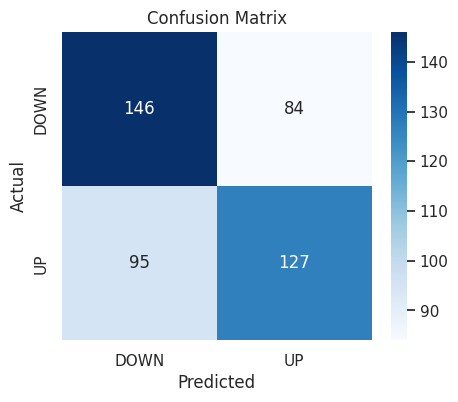

In [199]:
# Plot Confusion Matrix
print("\n📊 Plotting confusion matrix...")
plot_confusion_matrix(y_test, y_pred, label_names=["DOWN", "UP"])



📈 Plotting predictions...


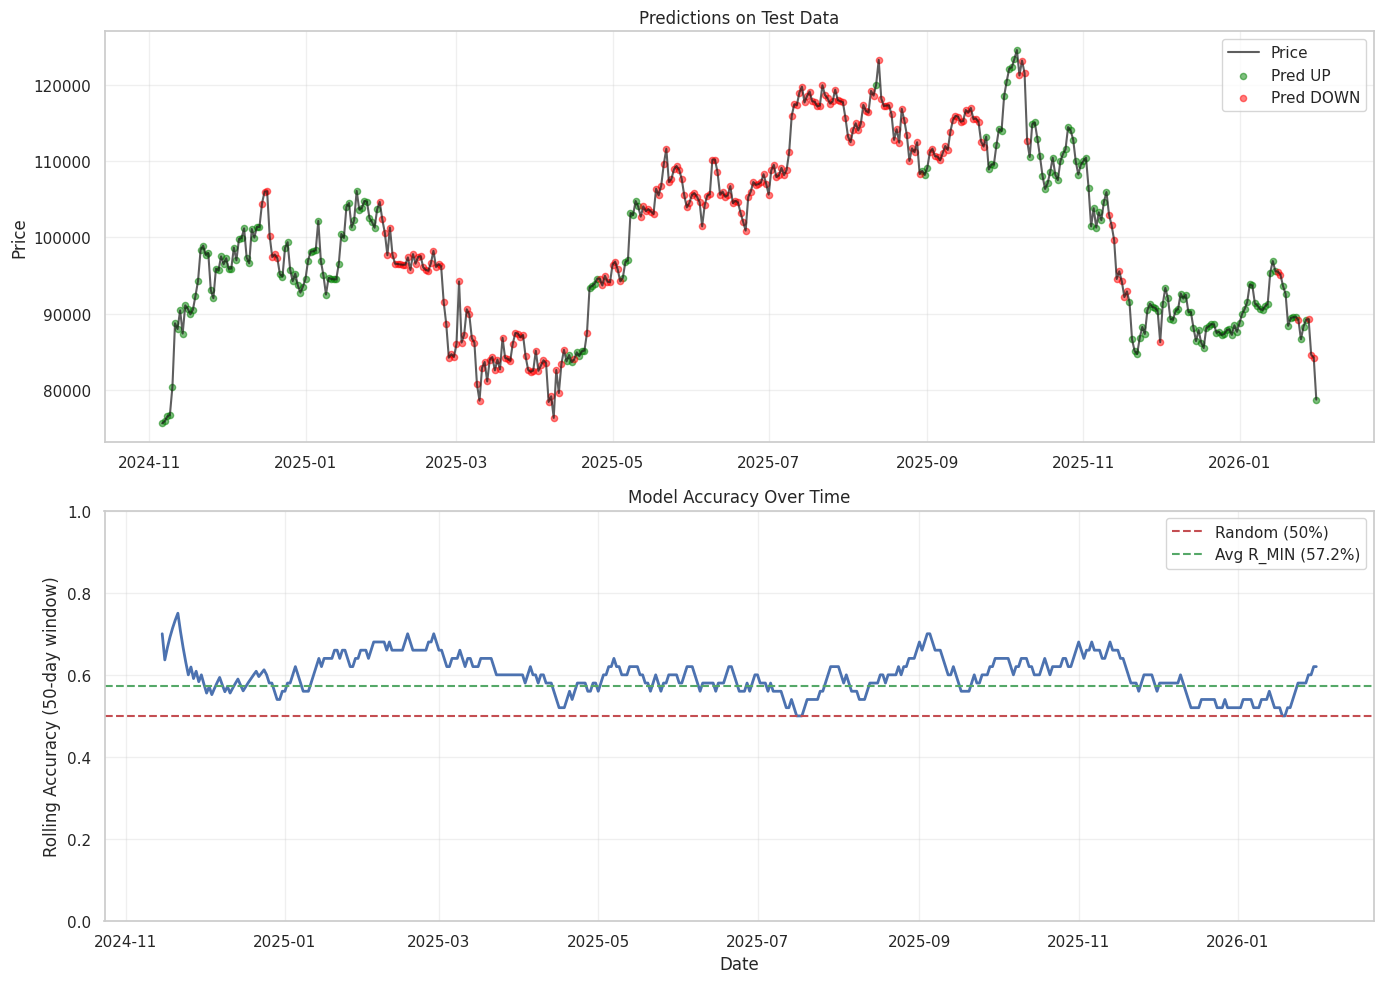

In [200]:
# Plot Predictions vs Actual
print("\n📈 Plotting predictions...")

# Добавляем цены для визуализации
test_df_plot = test_df.copy()
if "date" in test_df_plot.columns:
    test_df_plot["date"] = pd.to_datetime(test_df_plot["date"])
else:
    test_df_plot = test_df_plot.reset_index()
test_df_plot = test_df_plot.merge(
    df_market[["date", "close"]].assign(date=lambda x: pd.to_datetime(x["date"])), 
    on="date", 
    how="left",
    suffixes=("", "_market")
)
# Use market close if exists
if "close_market" in test_df_plot.columns:
    test_df_plot["close"] = test_df_plot["close_market"]

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Plot 1: Price with predictions
ax1 = axes[0]
ax1.plot(test_df_plot["date"], test_df_plot["close"], 'k-', alpha=0.7, label="Price")

# Highlight predictions
up_mask = y_pred == 1
down_mask = y_pred == 0
ax1.scatter(test_df_plot["date"].values[up_mask], test_df_plot["close"].values[up_mask], 
            c='green', alpha=0.5, s=20, label="Pred UP")
ax1.scatter(test_df_plot["date"].values[down_mask], test_df_plot["close"].values[down_mask], 
            c='red', alpha=0.5, s=20, label="Pred DOWN")
ax1.set_ylabel("Price")
ax1.set_title("Predictions on Test Data")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Accuracy over time (rolling)
ax2 = axes[1]
correct = (y_pred == y_test).astype(int)
rolling_acc = pd.Series(correct).rolling(50, min_periods=10).mean()
ax2.plot(test_df_plot["date"], rolling_acc, 'b-', linewidth=2)
ax2.axhline(y=0.5, color='r', linestyle='--', label="Random (50%)")
ax2.axhline(y=recall_min, color='g', linestyle='--', label=f"Avg R_MIN ({recall_min:.1%})")
ax2.set_ylabel("Rolling Accuracy (50-day window)")
ax2.set_xlabel("Date")
ax2.set_title("Model Accuracy Over Time")
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_ylim(0, 1)

plt.tight_layout()
plt.show()



📊 Feature Importance (Top 20)...


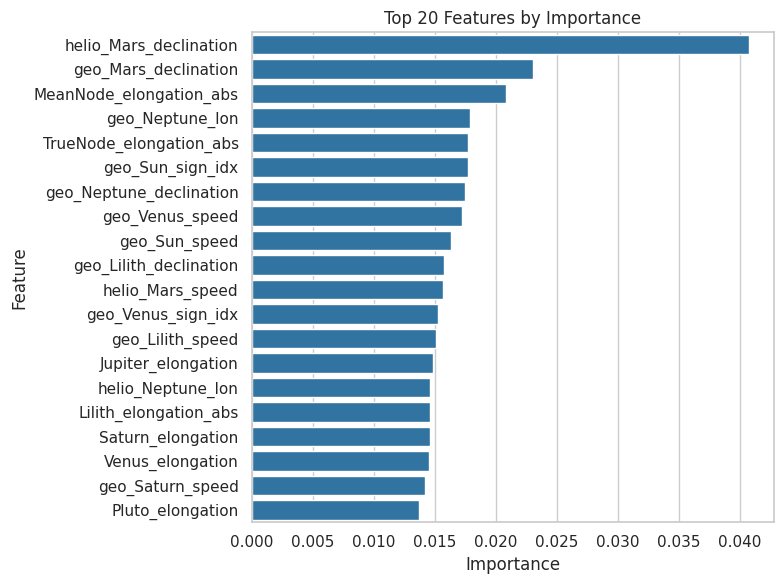

In [201]:
# Feature Importance
print("\n📊 Feature Importance (Top 20)...")
from RESEARCH.model_training import get_feature_importance
importance_df = get_feature_importance(model, feature_cols, top_n=20)
plot_feature_importance(importance_df, title="Top 20 Features by Importance")


In [202]:
# ══════════════════════════════════════════════════════════════════════════════════
# 💾 SAVE FINAL MODEL
# ══════════════════════════════════════════════════════════════════════════════════

from joblib import dump

artifact_dir = PROJECT_ROOT / "models_artifacts"
artifact_dir.mkdir(parents=True, exist_ok=True)

artifact = {
    "model": model.model,
    "scaler": model.scaler,
    "feature_names": feature_cols,
    "threshold": best_threshold,
    "config": {
        "astro_config": config,
        "xgb_params": BEST_PARAMS,
    },
    "metrics": {
        "recall_up": recall_up,
        "recall_down": recall_down,
        "recall_min": recall_min,
        "recall_gap": recall_gap,
    }
}

model_name = f"xgb_astro_{ACTIVE_CONFIG.lower()}.joblib"
out_path = artifact_dir / model_name
dump(artifact, out_path)
print(f"\n💾 Model saved: {out_path}")

print("\n" + "=" * 80)
print("✅ ANALYSIS COMPLETE!")
print("=" * 80)
print(f"""
📊 Final Results:
   Config:     {config['name']}
   R_MIN:      {recall_min:.3f}
   R_UP:       {recall_up:.3f}
   R_DOWN:     {recall_down:.3f}
   Gap:        {recall_gap:.3f}
   Threshold:  {best_threshold:.3f}
   
🌳 Best XGBoost Params:
   {BEST_PARAMS}
   
💾 Model saved to: {out_path}
""")



💾 Model saved: /home/rut/ostrofun/models_artifacts/xgb_astro_config_2.joblib

✅ ANALYSIS COMPLETE!

📊 Final Results:
   Config:     New Best (both -Uranus,Pluto)
   R_MIN:      0.572
   R_UP:       0.572
   R_DOWN:     0.635
   Gap:        0.063
   Threshold:  0.500

🌳 Best XGBoost Params:
   {'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.05, 'subsample': 0.8, 'colsample_bytree': 0.8, 'early_stopping_rounds': 50}

💾 Model saved to: /home/rut/ostrofun/models_artifacts/xgb_astro_config_2.joblib

